# DS-HK-9

### Regression Analysis Group Presentation


#### Wine Quality Data Set 



In [172]:
from IPython.display import Image
Image(url='http://archive.ics.uci.edu/ml/assets/logo.gif')

- Two datasets were created, using red and white variants of the Portuguese "Vinho Verde" wine.
- The inputs include objective tests (e.g. PH values) and the output is based on sensory data(median of at least 3 evaluations made by wine experts).
- Each expert graded the wine quality between 0 (very bad) and 10 (very excellent).

# Set up environment

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrices, dmatrix
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

import plotly
import plotly.tools as tls
from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode()

import cufflinks as cf
cf.go_offline()

%matplotlib inline

#DATA_DIR = '../data/'


# Initial Data Analysis

In [3]:
df = pd.read_csv("winequality-red.csv", sep = ';')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Data is quite clean

In [5]:
# Cleaning up column names
df.columns = ['fixedacid', 'volacid', 'citacid',
       'ressugar', 'chlorides', 'freeso2',
       'totals02', 'density', 'ph', 'sulphates', 'alcohol','quality']

In [6]:
df.describe()

fixedacid      volacid      citacid     ressugar    chlorides  \
count  1599.000000  1599.000000  1599.000000  1599.000000  1599.000000   
mean      8.319637     0.527821     0.270976     2.538806     0.087467   
std       1.741096     0.179060     0.194801     1.409928     0.047065   
min       4.600000     0.120000     0.000000     0.900000     0.012000   
25%       7.100000     0.390000     0.090000     1.900000     0.070000   
50%       7.900000     0.520000     0.260000     2.200000     0.079000   
75%       9.200000     0.640000     0.420000     2.600000     0.090000   
max      15.900000     1.580000     1.000000    15.500000     0.611000   

           freeso2     totals02      density           ph    sulphates  \
count  1599.000000  1599.000000  1599.000000  1599.000000  1599.000000   
mean     15.874922    46.467792     0.996747     3.311113     0.658149   
std      10.460157    32.895324     0.001887     0.154386     0.169507   
min       1.000000     6.000000     0.990070     2.740000     0.330000   
25%       7.000000    22.000000     0.995600     3.210000     0.550000   
50%      14.000000    38.000000     0.996750     3.310000     0.620000   
75%      21.000000    62.000000     0.997835     3.400000     0.730000   
max      72.000000   289.000000     1.003690     4.010000     2.000000   

           alcohol      quality  
count  1599.000000  1599.000000  
mean     10.422983     5.636023  
std       1.065668     0.807569  
min       8.400000     3.000000  
25%       9.500000     5.000000  
50%      10.200000     6.000000  
75%      11.100000     6.000000  
max      14.900000     8.000000

# Exploratory Data Analysis

## Univariate Analysis

In [7]:
df.iplot(kind='box', subplots = True, shape = (3,4), dimensions = (980,1200), legend = False, title = 'Univariate Box Plots')

The box plots of ressugar and chlorides indicate presence of outliers which should be explored

In [8]:
outliers = df[(df.chlorides > 0.3) | (df.ressugar> 7)] # to be used later


In [164]:
df.iplot(kind='hist', subplots = True, shape = (4,3), subplot_titles=True, dimensions = (980,1000), legend = False, title = 'Univariate Histograms')

In [27]:
len(df[df.citacid == 0])

132

The outliers in chlorides and ressugar are again apparent in the histograms. Most of the features seem to be reasonably distributed except for citacid which seems to be a bit skewed. A closer look indicates the almost 10% of the citacid values are 0. But it is difficult to know if thats an error due to lack of expertise in the subject. So this observation is ignored for further analysis. Lack of too much variation in the dependent variable 'quality' is a little bit of concern and raises the question of whether a Logistic Regression would be better suited. But for now, that issue is ignored and we decide to continue with linear regression. 

## Bivariate Analysis

In [10]:
cols = df.columns[:-1]
df.iplot(kind = 'scatter', 
         x = 'quality', 
         mode = 'markers', 
         symbol = 'x', 
         title = 'Scatter Plot of Quality vs Features', 
         size = 4, 
         bestfit = False,
         #keys = cols, 
         subplots= True, 
         subplot_titles = True, 
         dimensions = (980,1600)
        )

Due to a semi-categorical nature of the dependent variable, the bi-variate relationships are tougher to interpret. However, the following relationships to the dependent variables are observed.
- fixedacid: Weak linear
- volacid: Moderate linear 
- citacid: Moderate linear
- ressugar: Moderate 2nd degree
- chlorides: Strong 2nd degree
- freeso2: Strong 2nd degree 
- totals02: Moderate 2nd degree 
- density: Weak linear 
- ph: Weak linear
- sulphates: Moderate 2nd degree
- alcohol: Strong linear


In [105]:
#Prepare X and y
cols = df.columns[:-1]
X = df[cols]
y = df['quality']


## Test data for fit

In [108]:
from statsmodels.formula.api import ols

In [109]:
Xplus = X.copy()
Xplus = sm.add_constant(Xplus)
regress = sm.OLS(y,Xplus)
results = regress.fit()

In [110]:
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Sun, 12 Jun 2016   Prob (F-statistic):          1.79e-145
Time:                        23:56:17   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         21.9652     21.195      1.036      0.3

A quick test is done to determine the degree of fit to the data. The R-squared is found to be low indicating that the data may not yield a robust predictive model. However, a reasonably large F-stat indicates that the features have a relationship to the dependent variable. Hence the focus of the rest of the analysis shifts to determining a model that highlights the way the features influence the quality score of the wine.

A quick look at the p-values indicates that the features that seem to be most influential are alcohol, sulphates, totals02, chlorides and volacid. This seems to be in line with the visual inspection of the bivariate relationship.

The condition number is warned to be high indicating multi-collinearity. So further analysis of pairwise relationships of the features is warranted. Another problem observed is a non-robust covariance matrix which may indicate the presence of heteroscedasticity.

In [111]:
from sklearn.linear_model import Ridge
est = Ridge(normalize = False, alpha =.05, fit_intercept = False)
est.fit(X,y)
est.score(X,y)

0.36006522592329782

Both sm.ols and ridge regression provide similar r-squareds

# Feature Selection 

## Picking features by hand

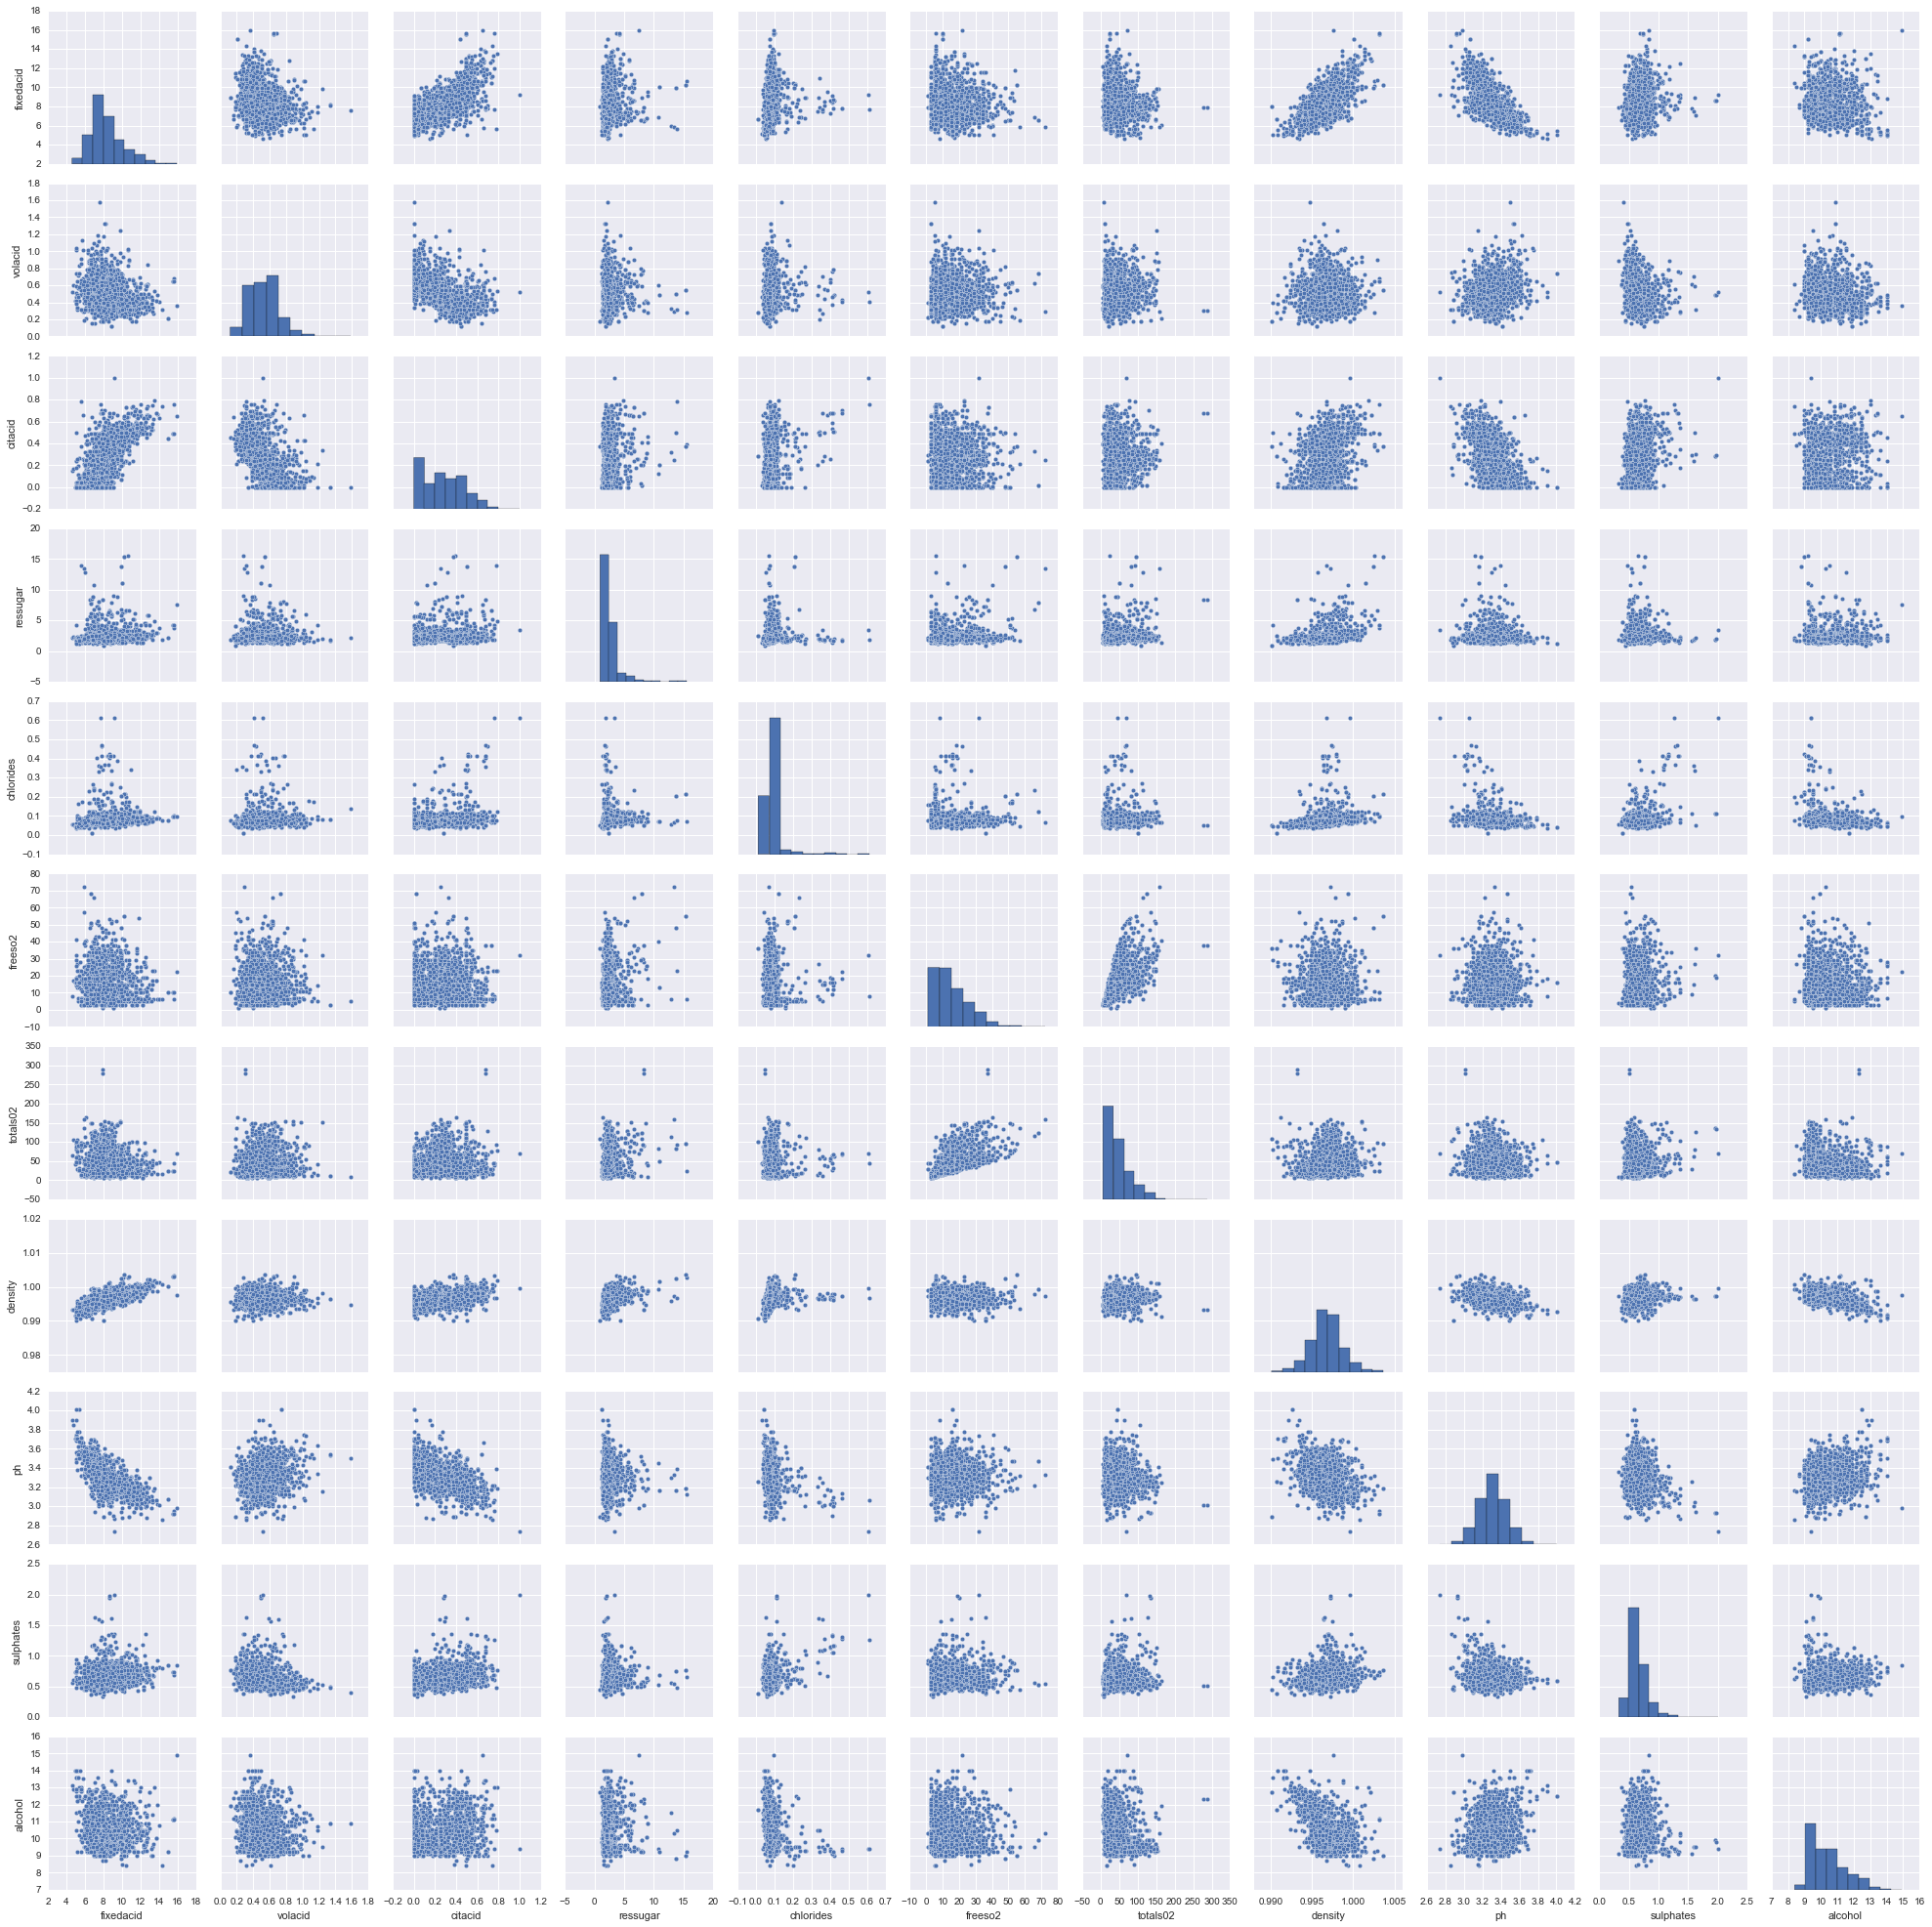

In [16]:
sns.pairplot(X)

An examination of scatter plots reveals that most pairwise relationships (except a few) are weak. The only correlations to watch out for are citacid/fixedacid, density/fixedacid, ph/fixedacid, freeso2/totalso2

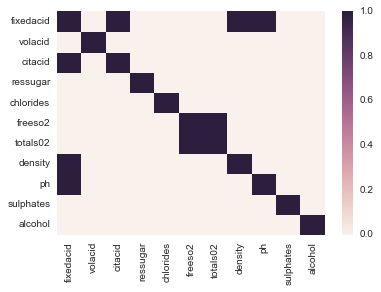

In [113]:
# Create correlation heatmap
sns.heatmap(np.abs(X.corr())>0.6)

The correlation heatmap confirms lack of strong pairwise correlations. None of the pairwise correlations are greater than 0.7 including the ones indicated by the scatter plots. Therefore multi-collinearity shouldnt be high. The high condition number thrown out by sm.ols might be indicating another problem.

In [114]:
from sklearn import feature_selection as fs

def f_regression_feature_selection(input, response):    
# use this against your feature matrix to determine p-values for
# each feature (we care about the second array it returns).
    return fs.univariate_selection.f_regression(input, response)

In [115]:
[F,p]=f_regression_feature_selection(X, y)
ps= zip(X.columns,p)
ranked_p = pd.DataFrame(sorted(ps, key=lambda x:x[1], reverse = False), columns = ['feature', 'p'])
ranked_p


feature             p
0     alcohol  2.831477e-91
1     volacid  2.051715e-59
2   sulphates  1.802088e-24
3     citacid  4.991295e-20
4    totals02  8.621703e-14
5     density  1.874957e-12
6   chlorides  2.313383e-07
7   fixedacid  6.495635e-07
8          ph  2.096278e-02
9     freeso2  4.283398e-02
10   ressugar  5.832180e-01

In [116]:
# Handpicked columns
feat_hp= ranked_p.feature
col_hp = list(feat_hp[:8])
col_hp

['alcohol',
 'volacid',
 'sulphates',
 'citacid',
 'totals02',
 'density',
 'chlorides',
 'fixedacid']

p_values from the univariate selection indicate that pH, freeSo2 and ressugar can be discarded. So we select the first 8 columns as the handpicked features. 

## Selecting features via recursive forward selection

Instead of adding features in the order of the univariate p_values, an attempt was made to recursively find the features by adding the best feature at every iteration (which adds the most to the score at each iteration)

In [117]:
scores = []
feats = []
features = feats[:]
for i in range(len(X.columns)-1):
    scores = []
    for feat in X.columns.difference(features):
        est = Ridge()
        feats = features[:]
        feats.append(feat)
        Xs = X[feats]
        #print feats
        est.fit(Xs, y)
        feats = features
        scores.append([feat,est.score(Xs,y)])
    dfz = pd.DataFrame(scores, columns=['a','s'])
    dfz.index = dfz.a
    #print dfz
    addfeat = dfz.s.argmax()
    print ('Added feature: ' + addfeat + ', new score is: ' + str(dfz.s.max()))
    features.append(addfeat)

Added feature: alcohol, new score is: 0.226734299343
Added feature: volacid, new score is: 0.316967026109
Added feature: sulphates, new score is: 0.33586639861
Added feature: totals02, new score is: 0.343751828747
Added feature: chlorides, new score is: 0.350879290299
Added feature: ph, new score is: 0.356332154507
Added feature: freeso2, new score is: 0.358615407846
Added feature: citacid, new score is: 0.35911556155
Added feature: ressugar, new score is: 0.359349520426
Added feature: fixedacid, new score is: 0.359479182064


In [118]:
col_fwd = features[:6]

Using a recursive method seems to change the order of inclusion of features. citacid drops down on the list while pH gains importance. We decide to cut off at 6 features as the rest of the features dont seem to add a lot to the score.

## Selecting features via RFE

In [119]:
stand_X = (X - X.mean()) / X.std()  # standardised features

In [120]:
from sklearn.feature_selection import RFE

# Create the RFE object and rank each features
est = Ridge(alpha = 100)
rfe = RFE(estimator=est, n_features_to_select=1, step=1)

rfe.fit(stand_X, y)
ranking = rfe.ranking_
            
scores = zip(stand_X.columns,ranking)
scores = sorted(scores, key=lambda x:x[1])
col_rfe = [x[0] for x in scores][:6]


In [121]:
scores

[('alcohol', 1),
 ('volacid', 2),
 ('sulphates', 3),
 ('chlorides', 4),
 ('totals02', 5),
 ('ph', 6),
 ('freeso2', 7),
 ('fixedacid', 8),
 ('density', 9),
 ('ressugar', 10),
 ('citacid', 11)]

## Results from different feature selection methods

In [122]:
print 'Handpicked columns:', col_hp
print 'Columns selected via fwd selection:', col_fwd
print 'Columns selected via RFE:', col_rfe

Handpicked columns: ['alcohol', 'volacid', 'sulphates', 'citacid', 'totals02', 'density', 'chlorides', 'fixedacid']
Columns selected via fwd selection: ['alcohol', 'volacid', 'sulphates', 'totals02', 'chlorides', 'ph']
Columns selected via RFE: ['alcohol', 'volacid', 'sulphates', 'chlorides', 'totals02', 'ph']


We notice that the same features are selected via RFE as well as the recursive forward selection. 

In [123]:
for feats in [col_hp, col_fwd, col_rfe]:
    est = Ridge()
    Xs = X[feats]
    print est.fit(Xs, y).score(Xs,y)

0.354070785466
0.356332154507
0.356332154507


Feature selection via recursive forward selection/RFE provided a better score than the hand picked columns inspite of selecting fewer columns. We shall use those features for further analysis

# Model fitting

We decide to use both statsmodel (for greater statistical insights) and sklearn ridge regression for analyis. Also we use standardised features for the analysis to compare coefficients and determine the features that are more important.

## Fitting 1st degree model

In [125]:
Xs = stand_X[col_fwd]
Xs = sm.add_constant(Xs)  #Add the constant 1 column to Xs for statsmodel

In [126]:
regress = sm.OLS(y,Xs)
results = regress.fit()

In [47]:
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     147.4
Date:                Sun, 12 Jun 2016   Prob (F-statistic):          7.12e-149
Time:                        23:40:40   Log-Likelihood:                -1573.4
No. Observations:                1599   AIC:                             3161.
Df Residuals:                    1592   BIC:                             3198.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.6360      0.016    347.419      0.0

We find that the R-square score has not suffered by dropping 5 of the features. Additionally, the condition number has dramatically improved and is no longer flashing a warning. However, the non-robust covariance matrix continues to be a concern. We shall try a higher order ploynomial form to figure out if that solves the problem.   

###  Analysis of the residuals

In [127]:
est = Ridge()
Xs = X[col_fwd]
est.fit(Xs,y)
yhat = est.predict(Xs) 

In [128]:
err = pd.DataFrame(y)
err['err'] = yhat-y
err.iplot(kind='scatter', x = 'quality', y = 'err', mode='markers', size = 4, dimensions = (980,420), xTitle = 'Actual values',
         yTitle = 'Residuals', title = 'Analysis of residuals' )
#err['err'].iplot(kind='hist')

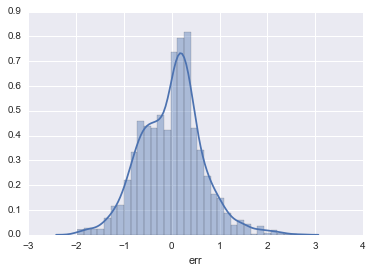

In [129]:
sns.distplot(err['err'], hist = True, kde = True )
#sns.kdeplot(err.err, shade=True, kde = True)

An analysis of residuals indicates clear issues. The scatter plot of residuals with actual values indicates a strong linearity indicating a strong heteroscedasticity. The lack of a curvature in the scatter plot seems to indicate that increasing the order may not help to  solve the problem and the problem may be that of a missing feature. The curve fitted to the histogram of the residuals confirms the non-normality of the residuals. 

### Impact of Lambda ridge coefficient on scores and coeff values

In [131]:
#Test to see if alphas have any impact on the fit or the scores 
n_alphas = 200
alphas = np.logspace(-10, 2, n_alphas)
clf = Ridge(fit_intercept=True)

coefs = []
scores = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(Xs, y)
    coefs.append(clf.coef_)
    scores.append(clf.score(Xs,y))


In [132]:
coefsdf = pd.DataFrame(coefs, columns = Xs.columns)
coefsdf['alpha'] = alphas
coefsdf['score'] = scores

In [133]:
coefsdf.iplot(kind = 'scatter', x = 'alpha', dimensions = (980,500), xTitle = 'Alpha', yTitle = 'Scores and coefficients',
             title = 'Impact of alpha on parameters and score', theme = 'solar')

While the small coefficients had already indicated that the lambda parameter may not have a big influence on the results, we plotted the influence of lambda on the coeffs and the score to confirm a complete lack of influence.

## Adding higher degree polynomials

Because visual inspection had indicated that 2nd degree terms might be useful, we add squared terms to the regression model and then standardise the features to reduce multi-collinearity

In [134]:
Xs = X[col_fwd]
for feat in Xs.columns:
    Xs['sq_'+feat] = Xs[feat]**2 

stand_Xs = (Xs - Xs.mean()) / Xs.std() 
est = Ridge()
est.fit(stand_Xs,y)
score = est.score(stand_Xs,y)
print 'score = ' + str(score)


/Users/Sekhri/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



score = 0.3779701092


We find that there is a small improvement in score after adding squared terms. We look at statsmodels output to see which coefficients are significant

In [135]:
stand_Xs = sm.add_constant(stand_Xs) 
regress = sm.OLS(y,stand_Xs)
results = regress.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     80.39
Date:                Sun, 12 Jun 2016   Prob (F-statistic):          4.72e-154
Time:                        23:58:09   Log-Likelihood:                -1546.7
No. Observations:                1599   AIC:                             3119.
Df Residuals:                    1586   BIC:                             3189.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            5.6360      0.016    352.582   

Some of the variables indicate very small p_values and seemed to have unbalanced the regression. So we drop some squared terms one by one and  try again.

In [136]:
dropcols = 'sq_ph sq_volacid sq_totals02 sq_chlorides sq_alcohol'.split()
stand_Xs.drop(dropcols, axis = 1, inplace=True)

In [137]:
regress = sm.OLS(y,stand_Xs)
results = regress.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     136.9
Date:                Sun, 12 Jun 2016   Prob (F-statistic):          6.80e-158
Time:                        23:58:17   Log-Likelihood:                -1549.8
No. Observations:                1599   AIC:                             3116.
Df Residuals:                    1591   BIC:                             3159.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            5.6360      0.016    352.463   

We find that only sq_sulphates seems to be needed. Dropping the rest of squared terms has almost no impact on the score and in fact improves the parameters by reducing multi-collinearity.

### Analysis of residuals of higher order model

In [139]:
err = pd.DataFrame(y)
est.fit(stand_Xs,y)
yhat = est.predict(stand_Xs)
err['err'] = yhat-y
err.iplot(kind='scatter', x = 'quality', y = 'err', mode='markers', size = 4)

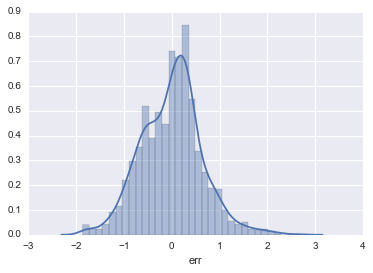

In [140]:
sns.distplot(err['err'], hist = True, kde = True )

We find that the presence of one of the squared terms doesnt improve the quality of the residuals noticeably. However, given the significance of p_value, we shall use that in our final model. 

## Testing the robustness of the regression

In order to test if the regression is stable for different sample cuts and for out of sample values, we randomly shuffled the data into training and test data sets to determine if the scores were stable.

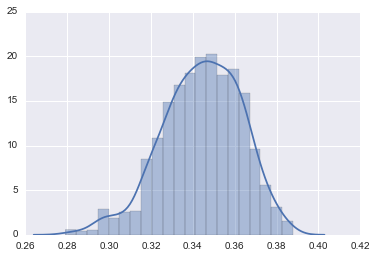

In [154]:
Xs = X[col_fwd]

scores = [ ]
ynew = y.copy()

# Shuffle the  samples
import random
for state in range(0,10000,10):
    irange = range(len(X))
    rng = np.random.RandomState(state)
    rng.shuffle(irange)

    Xs = Xs.reindex(irange)
    ynew = ynew.reindex(irange)
    Xtrain = Xs[:750]
    ytrain = ynew[:750]
    Xtest = Xs[750:]
    ytest = ynew[750:]
    est = Ridge()
    est.fit(Xtrain,ytrain)
    score = est.score(Xtest,ytest)
    scores.append(score)

sns.distplot(scores)

#print 'score = ' + str(score)
#yhat = est.predict(Xs) 
#err = pd.DataFrame(ynew)
#err['err'] = yhat-ynew
#err['yhat'] = yhat

#err.iplot(kind='scatter', x = 'quality', y = 'err', mode='markers', size = 4, dimensions = (980,600))

In [143]:
y.index

RangeIndex(start=0, stop=1599, step=1)

We find the out of sample scores are reasonably distributed around 0.35 for out of sample prediction. While we were mot looking to create a predictive model, out of sample testing this way indicates that results we obtain are sensible and robust.

## Conclusions

The final model obtained provided the following results
1. Positively correlated features:
    - Alcohol
    - Sulphate content (with the presence of a square term)
1. Negatively correlated features:
    - Volatile Acidity
    - Total Sulphur dioxide
    - Chloride content
    - lower pH (so higher acidity)

Research notes:
- Alcohol appears to be the main determinant of quality, which reflects the demand for more robust-flavoured wines
- Volatile acidity is the next highly correlated
  And is mostly caused by bacteria in the wine, creating acetic acid 
  this can come from many factors- fruit flies, contamination of the processing buckets etc). 
- SO2 is typically used to kill microbes
- chlorides can cause saltinesss in wines and are attributed to the minerals in the soil. 
  http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-20612015000100095 
  shows that France has the least chlorides in the soil
  which may explain why french bordeauxs are so great!

# Logistic Regression 

Given the fact that the quality score was almost categorical, we decided to try logistic regression as well and see what comes out of that.

In [155]:
#creating 2 bins  (0,5] being bad score and (5,10] being good score
bins = [0,5,10]
ybin = pd.cut(y, bins, labels = [0,1])

stand_X = (X-X.mean())/X.std()

In [157]:
data = pd.concat([stand_X,ybin], axis = 1)

### EDA

In [158]:
dfg = data.groupby('quality').mean().T
dfg.columns = ['bad', 'good']
dfg['diff']=dfg.loc[:,'good'] - dfg.loc[:,'bad'] #Calc difference in mean value of feature between the 2 categories 
dfg['absdiff']=np.abs(dfg['diff']) #calc abs value of above diff
dfg.sort_values('absdiff') # sort by abs value of diff

bad      good      diff   absdiff
ressugar   0.002315 -0.002015 -0.004330  0.004330
ph         0.003498 -0.003044 -0.006542  0.006542
freeso2    0.066183 -0.057591 -0.123773  0.123773
fixedacid -0.101909  0.088679  0.190587  0.190587
chlorides  0.117341 -0.102108 -0.219449  0.219449
density    0.170513 -0.148376 -0.318890  0.318890
citacid   -0.170534  0.148395  0.318929  0.318929
sulphates -0.233701  0.203361  0.437061  0.437061
totals02   0.248588 -0.216315 -0.464902  0.464902
volacid    0.344478 -0.299757 -0.644235  0.644235
alcohol   -0.465909  0.405423  0.871332  0.871332

By sorting the absolute value of the above difference, we figure out which of the features has the highest separation between the good and bad wines. We find that the top features are alcohol, volacid, totals02, sulphates, citacid and density. So there is quite a common fit between the features selected in the linear regression and what appear to be the best features in classification analysis.

*Linear regression features were ['alcohol', 'volacid', 'sulphates', 'chlorides', 'totals02', 'ph']


In [160]:
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression as logistic
scores = []
feats = []
features = feats[:]
for i in range(len(stand_X.columns)-1):
    scores = []
    for feat in stand_X.columns.difference(features):
        
        feats = features[:]
        feats.append(feat)
        stand_Xs = stand_X[feats]
        #print feats
        est = logistic()
        est.fit(stand_Xs, ybin)
        feats = features
        scores.append([feat,est.score(stand_Xs, ybin)])
    dfz = pd.DataFrame(scores, columns=['a','s'])
    dfz.index = dfz.a
    #print dfz
    addfeat = dfz.s.argmax()
    print ('Added feature: ' + addfeat + ', new score is: ' + str(dfz.s.max()))
    features.append(addfeat)
    fwdlogitcols = features[:5] 


Added feature: alcohol, new score is: 0.703564727955
Added feature: volacid, new score is: 0.737961225766
Added feature: ph, new score is: 0.741088180113
Added feature: chlorides, new score is: 0.742338961851
Added feature: ressugar, new score is: 0.741713570982
Added feature: density, new score is: 0.737961225766
Added feature: totals02, new score is: 0.739212007505
Added feature: freeso2, new score is: 0.744215134459
Added feature: sulphates, new score is: 0.747342088806
Added feature: fixedacid, new score is: 0.747967479675


### Feature selction via RFE

In [159]:
# Create the RFE object and rank each features

rfeest = logistic()
rfe = RFE(estimator=rfeest, n_features_to_select=1, step=1)

rfe.fit(stand_X, ybin)
ranking = rfe.ranking_
            
scores = zip(stand_X.columns,ranking)
scores = sorted(scores, key=lambda x:x[1])
rfelogitcols = [x[0] for x in scores][:6]
rfelogitcols

['alcohol', 'volacid', 'totals02', 'sulphates', 'citacid', 'fixedacid']

In [163]:
print "Linear Regression features: " + str(['alcohol', 'volacid', 'sulphates', 'chlorides', 'totals02', 'ph'])
print "Logistic Regression features:", rfelogitcols

Linear Regression features: ['alcohol', 'volacid', 'sulphates', 'chlorides', 'totals02', 'ph']
Logistic Regression features: ['alcohol', 'volacid', 'totals02', 'sulphates', 'citacid', 'fixedacid']


In [61]:
# Checking which feature selection is better
for feat in [logitcols, rfelogitcols]:
    logist = logistic()
    logist.fit(stand_X[feat],ybin)
    print 'score: '+ str(logist.score(stand_X[rfelogitcols],ybin))
#reslogit =  pd.DataFrame(zip(rfelogitcols,logist.coef_[0]))
#print reslogit

score: 0.459036898061
score: 0.746716697936


## Regression from Handpicked features

In [161]:
logitcols = [ u'volacid', u'chlorides', u'freeso2', u'totals02', u'sulphates', u'alcohol']
logit = sm.Logit(ybin, stand_X[logitcols])
result = logit.fit()
print result.summary()


Optimization terminated successfully.
         Current function value: 0.525288
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                quality   No. Observations:                 1599
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Jun 2016   Pseudo R-squ.:                  0.2395
Time:                        00:06:25   Log-Likelihood:                -839.94
converged:                       True   LL-Null:                       -1104.5
                                        LLR p-value:                4.167e-112
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
volacid       -0.5124      0.066     -7.724      0.000        -0.642    -0.382
chlorides     -0.2086      0.

## Model fitting

In [162]:
stand_Xs = stand_X.copy()
logit = sm.Logit(ybin, stand_Xs[rfelogitcols])
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.527167
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                quality   No. Observations:                 1599
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Jun 2016   Pseudo R-squ.:                  0.2368
Time:                        00:06:31   Log-Likelihood:                -842.94
converged:                       True   LL-Null:                       -1104.5
                                        LLR p-value:                8.265e-111
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
alcohol        0.9849      0.072     13.656      0.000         0.844     1.126
volacid       -0.7008      0.

## Conclusions

All p-values are significant. Overall score as provided by Ridge model is 0.74 while pseudo-r-square is 0.2368. The p-value for the overall regression is very low indicating a low likelihood of spurious relationship. Overall the RFE features provided a better result so we stick to that.

We find that the feature selection is quite similar between both linear and logistic regressions. We find that the signs of the relationships between the variables are all preserved.

From logistic regression, we observe that alchohol content, sulphates and fixed acidity  are higher in good wines and at the same time volatile acidity, total Sulphur dioxide and citric acid content are lower in the good wines. 



# Thank You!

In [176]:
Image(url='http://i.imgur.com/z1W5auA.gif')